- A well justified evaluation framework.
- Pre-processing the data set to make it suitable for providing to various machine learning algorithms.
- Carefully selected and justified baseline model(s).
- Hyper-parameter setting and tuning to refine the model.
- Analysing model and outputs & interpreting the trained models


This study involves 100 H&E stained histology images of colorectal adenocarcinomas. 
In reality we are classifying the nuclei type.
TODO: softmax CNN + NEP for classifying cell types

TODO: transfer learning, use one pre-trained model as basis for 2nd one, aka use extraData classification for mainData classification 
TODO: how to use the extra data:
Another approach is to use the extraData dataset as a source of unlabeled data for semi-supervised learning. In this approach, you can use the extraData dataset to train an unsupervised model, such as an autoencoder, to learn the underlying features of the cell images. Then, you can use the learned features as inputs to a supervised model, which can be trained on the labeled data from the mainData dataset. This approach can help the model learn more robust representations of the cell images, which can lead to better classification performance even with limited labeled data.
TODO: visual transformers?? 16x16 better kernel, more resources to train

TODO:
Eval metrics: Weighted average F1-score, Multi-class AUC, Epithelial Precision (for isCancerous) 


Bibliography:
"Adam: A Method for Stochastic Optimization"
Original paper: http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf
https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/legacy/SGD
rccnet: https://arxiv.org/pdf/1810.02797.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import pandas as pd
from PIL import Image
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, add, GlobalAveragePooling2D, Dense, MaxPooling2D, Flatten
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for visualizing the model using plot_model
# !pip install pydot

In [2]:
data = pd.read_csv('Image_classification_data/data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


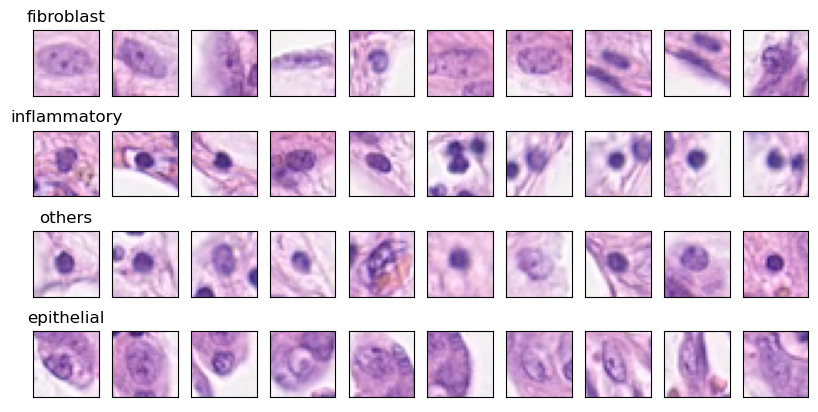

In [3]:
def cell_image(imageName):
    return Image.open('Image_classification_data/patch_images/' + imageName)


rows = 20
    
# # Convert to RGB mode (if not already in RGB mode)
# img = img.convert("RGB")

# # Get the RGB pixel values as a list of tuples
# rgb_pixels = list(img.getdata())

    
# Source: Week 4 Lecture Q and A

plt.figure(figsize=(10,5))
cell_types = data['cellTypeName'].unique()
for i, cell_type in enumerate(cell_types):
    cell_type_data = data[data['cellTypeName'] == cell_type][:10] 
    for j, image_name in enumerate(cell_type_data['ImageName']):
        plt.subplot(len(cell_types), 10, (i*10)+j+1) 
        plt.imshow(cell_image(image_name)) 
        plt.xticks([])
        plt.yticks([])
        if j==0:
            plt.title(cell_type) 
plt.show()

## Image averaging
Epithelial have  the weakest nuclei positioning, as the center position is blurred, while inflammatory cells have the strongest.
The colour of epithelial cells is a stronger hue of purple, which may contribute to its morphology to distinguish its type.

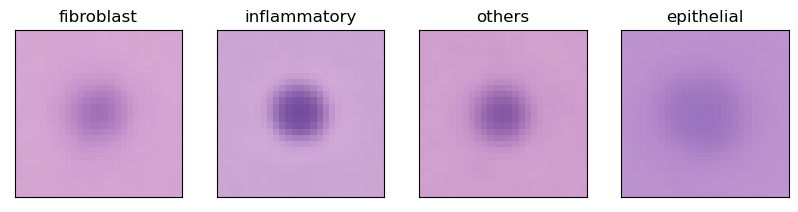

In [4]:
# Get the average cell image from all cell images 
# filter the data to only include images with the chosen cell type
plt.figure(figsize=(10,10))
for i, cell_type in enumerate(cell_types):
    cell_type_data = data[data['cellTypeName'] == cell_type]
    image_arrays = [np.array(cell_image(image_name)) for image_name in cell_type_data['ImageName']]
    average_array = np.mean(image_arrays, axis=0).astype(np.uint8)
    average_image = Image.fromarray(average_array)
    plt.subplot(len(cell_types), 4, i+1) 
    plt.imshow(average_image)
    plt.xticks([])
    plt.yticks([])
    plt.title(cell_type)
plt.show()

"In classification, morphology of nuclei (shape, size, color, and texture) is
necessary to distinguish between different types of them. Raw RGB color intensities which constitute the overall visual
appearance of nuclei were, thus, chosen as input features to
softmax CNN for each patch."
Based on paper, only 1 channel was used for colour intensity. But as mentioned, the colour is also necessary. Epithelial cells appear to have a separate colour entirely, and seems to have a strong correlation to cancerous cells. For this reason, improvements to the CNN's baseline involves making the input shape have 3 channels.

# Get value counts of categorical variables
for column in {'cellTypeName', 'cellType', 'isCancerous'}:
    print(pd.value_counts(data[column]))
data.head()

# Get total unique patients
patients = len(data['patientID'].unique())
print(f"There are {patients} unique patients")

Cell type simply corresponds to the cell type name. To avoid affecting the model, we will take out the duplicate column
The instance ID is an ID column to uniquely identify the patient and cell together, so it is not necessary for analysis.

In [5]:
if 'InstanceID' in data.columns:
    data = data.drop(columns=['InstanceID', 'cellType'])
data.head()

,patientID,ImageName,cellTypeName,isCancerous
0,1,22405.png,fibroblast,0
1,1,22406.png,fibroblast,0
2,1,22407.png,fibroblast,0
3,1,22408.png,fibroblast,0
4,1,22409.png,fibroblast,0


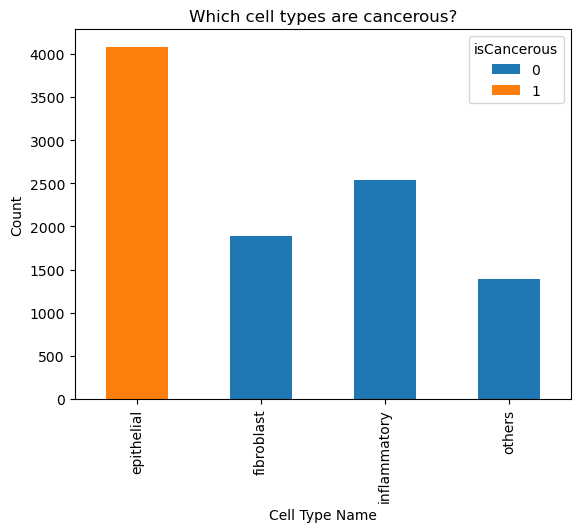

In [6]:
# Stacked bar chart 
grouped_data = data.groupby(['cellTypeName', 'isCancerous']).size().reset_index(name='count')
pivoted_data = grouped_data.pivot(index='cellTypeName', columns='isCancerous', values='count')
pivoted_data.plot(kind='bar', stacked=True)
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.title('Which cell types are cancerous?')
plt.show()

The dataset indicates that most cancer cells are epithelial in nature. However, the other cells may still play a role in cancer development. An example of this is inflammation cells causing chronic inflammation, which can damage DNA and other cellular components leading to cancer. [Link](https://www.cancer.gov/news-events/cancer-currents-blog/2022/reducing-inflammation-to-treat-cancer#:~:text=In%20a%20normal%20inflammatory%20response,that%20could%20lead%20to%20cancer)

TODO:
For this, it will be useful to identify the distribution of these cells per patient.

Other points:
- the extra data set may give better insight into classifying. first use both to classify cell type, then use to predict isCancerous

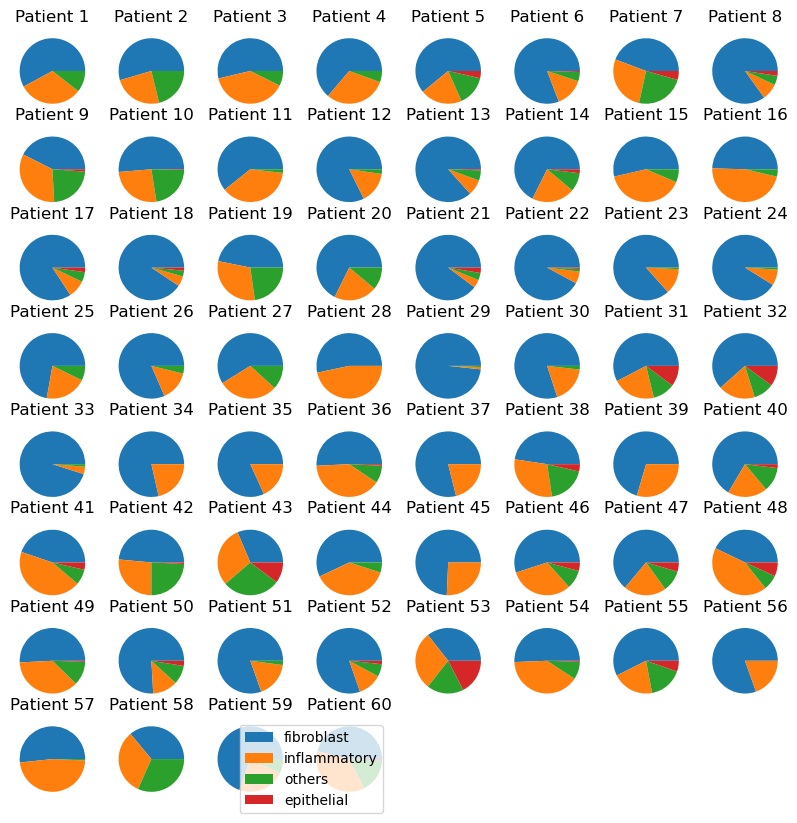

In [7]:

fig = plt.figure(figsize=(10,10))
for i, (patient_id, group) in enumerate(data.groupby("patientID")):
    cell_type_counts = group["cellTypeName"].value_counts()
    ax = fig.add_subplot(8, 8, i+1)
    
    ax.pie(cell_type_counts)
    ax.set_title(f"Patient {patient_id}")
plt.legend(data["cellTypeName"].unique())
plt.show()

We have identified that there are 60 unique patients in our dataset, with multiple cells allocated to each patient.
To avoid data leakage, we need to group any data for each patient and split the data such that there is no overlap of patient data between train, validation and test sets.

One more problem is ensuring that we maintain a rough 60-20-20 split, as certain patients may contain a larger proportion of the dataset, which may cause uneven distribution. This is another reason we specify a random state


In [8]:
# 60-20-20 split
def group_split(test_size, data):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

    # Split the data into training and test sets
    for train_idx, test_idx in gss.split(data, groups=data['patientID']):
        train_data = data.loc[train_idx]
        test_data = data.loc[test_idx]
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)


train_data, test_data = group_split(0.2, data)
train_data, val_data = group_split(0.25, train_data)

In [9]:
train_patients = train_data['patientID'].unique()
test_patients = test_data['patientID'].unique()
val_patients = val_data['patientID'].unique()
all_patients = np.unique(np.concatenate((train_patients, test_patients, val_patients), axis=0))
print(f"There are {len(all_patients)} unique patients after splitting, spread across the train, test and validation sets.")
overlap = len(np.intersect1d(train_patients, test_patients))

def overlap(train_data, test_data):
    train_patients = train_data['patientID'].unique()
    test_patients = test_data['patientID'].unique()
    return len(np.intersect1d(train_patients, test_patients))

print(f"There is {overlap(train_data, test_data)} overlap between the train and test patient data")
print(f"There is {overlap(train_data, val_data)} overlap between the train and validation patient data\n")

# Calculate the proportions of each dataset
train_prop = len(train_data) / len(data)
test_prop = len(test_data) / len(data)
val_prop = len(val_data) / len(data)

print(f"Train proportion: {train_prop:.2f}")
print(f"Test proportion: {test_prop:.2f}")
print(f"Validation proportion: {val_prop:.2f}")

There are 60 unique patients after splitting, spread across the train, test and validation sets.
There is 0 overlap between the train and test patient data
There is 0 overlap between the train and validation patient data

Train proportion: 0.63
Test proportion: 0.18
Validation proportion: 0.19


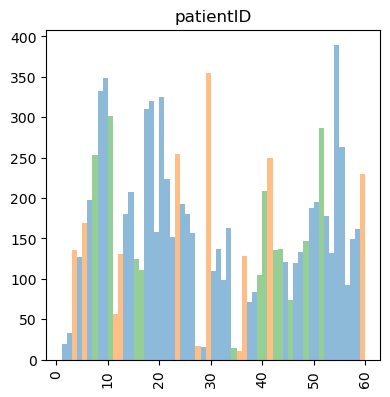

In [10]:
plt.figure(figsize=(25,30))
plt.subplot(6,5,1)
plt.hist(train_data['patientID'], bins = all_patients, alpha=0.5)
plt.hist(test_data['patientID'], bins = all_patients, alpha=0.5)
plt.hist(val_data['patientID'], bins = all_patients, alpha=0.5)
plt.title('patientID')
plt.xticks(rotation='vertical')
print()

# Data Augmentation
"For both networks, we arbitrary rotated patches (0◦, 90◦, 180◦, 270◦) and flipped them along vertical or horizontal axis to alleviate the rotation-variant problem of the input features."

In [11]:
# baseline colour perturbation specified
def perturb_color(img):
    img_uint8 = (img * 255).astype('uint8')
    img = Image.fromarray(img_uint8)
    img = img.convert('HSV')
    rH = np.random.uniform(0.95, 1.05)
    rS = np.random.uniform(0.9, 1.1)
    rV = np.random.uniform(0.9, 1.1)
    img_hsv = np.array(img)
    img_hsv[..., 0] = np.clip(img_hsv[..., 0] * rH, 0, 179)
    img_hsv[..., 1] = np.clip(img_hsv[..., 1] * rS, 0, 255)
    img_hsv[..., 2] = np.clip(img_hsv[..., 2] * rV, 0, 255)
    img_rgb = Image.fromarray(img_hsv, mode='HSV').convert('RGB')
    img_array = np.array(img_rgb) / 255.0
    return img_array

In [12]:

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    data_format='channels_last', 
    rotation_range=90, 
    horizontal_flip=True, 
    vertical_flip=True,
#     preprocessing_function=lambda x: perturb_color(x)
)

val_datagen = ImageDataGenerator(
    rescale=1./255, 
    data_format='channels_last'
)

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        # avoid overfitting with lower batch size
        batch_size=32,
        class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='Image_classification_data/patch_images',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=32,
        class_mode='categorical'
)


Found 6261 validated image filenames belonging to 4 classes.
Found 1899 validated image filenames belonging to 4 classes.


We will attempt to use (based on section V of http://wrap.warwick.ac.uk/77351/7/WRAP_tmi2016_ks.pdf)

Section VI C
"We initialized all weights with 0 mean and 10−2 standard deviation Gaussian random numbers. All biases were set to 0.
The networks were trained using stochastic gradient descent with momentum 0.9 and weight decay 5 × 10−4 for 120 epochs. We annealed the learning rate, starting from 10−2 for the first 60 epochs, then 10−3 for the next 40 epochs, and 10−4 for the last 20 epochs. We used 20% of training data for validation. The optimal networks for SC-CNN and softmax CNN were selected based on the root mean square error and the classification error on the validation set, respectively."
- Softmax CNN for the output layer
- Cross-entropy (The following logarithmic loss is employed to train the network via solving)
- SGD for optimizer (The networks were trained using stochastic gradient descent with momentum 0.9 and weight decay 5 × 10−4 for 120 epochs.)

"In both networks, a rectified linear unit (ReLU)
activation function [32] was used after each convolution layer
and the first two fully-connected layers (1st, 3rd, 5th and 6th
layer). To avoid over-fitting, dropout [33] was implemented in
the first-two fully-connected layers (5th and 6th layer, after
ReLU is applied) with a dropout rate of 0.2. We implemented
both networks using MatConvNet [34]."

| Layer | Type       | Filter Dimensions | Input/Output Dimensions |
|-------|------------|------------------|-------------------------|
| 0     | Input      | -                | 27 X 27 X 1             |
| 1     | Convolution| 4 X 4 X 1 X 36         | 24 X 24 X 36            |
| 2     | Max-pooling| 2 X 2            | 12 X 12 X 36            |
| 3     | Convolution| 3 X 3 X 36 X 48   | 10 X 10 X 48            |
| 4     | Max-pooling| 2 X 2            | 5 X 5 x 48              |
| 5     | Fully-connected | 5 X 5 X 48 X 512   | 1 x 512                 |
| 6     | Fully-connected | 1 X 1 X 512 X 512  | 1 X 512                 |
| 7     | Fully-connected | 1 X 1 X 512 X 4    | 1 X 4                   |

Considerations: input dimension of 27x27x1 implies only 1 channel,  while the RGB images have 3. This implies the CNN can only see the intensity of the image, but not the colour information, which is important for determining the cell type.

In [13]:
def softmax_CNN(input_shape, optimizer):
    model = Sequential()
    # Convolutional Layer 1
    model.add(Conv2D(filters=36, kernel_size=(4, 4), activation='relu', input_shape=input_shape))
    # Max Pooling Layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Convolutional Layer 2
    model.add(Conv2D(filters=48, kernel_size=(3, 3), activation='relu'))
    # Max Pooling Layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # flatten H X W x Channels to 1D 
    model.add(Flatten())
    # Fully Connected Layer 1
    model.add(Dense(units=512, activation='relu'))
    # Fully Connected Layer 2
    model.add(Dense(units=512, activation='relu'))
    # Output Layer
    model.add(Dense(units=4, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    return model
    # plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
# the paper starts with learning rate of 
sgd = tf.keras.optimizers.SGD(decay=0.0005, momentum=0.9)
baseline = softmax_CNN(input_shape=(27,27,1), optimizer='SGD')
baseline.summary()
baseline.fit(train_generator, epochs=10, validation_data=val_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 36)        612       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 36)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 48)        15600     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 48)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1200)              0         
                                                                 
 dense (Dense)               (None, 512)               6

- need 3 dimensions
- use adam instead of SGD (automatically adapts learning rate, rather than manually annealing it), discovered only a year before this papers publication in 2015
- data augmentation

In [15]:
# the input shape will now take all 3 RGB channels
# no need to manually anneal learning rate, use ADAM
improved_CNN = softmax_CNN(input_shape=(27,27,3), optimizer='adam')
history = improved_CNN.fit(train_generator, epochs=20, validation_data=val_generator)

# data augmentation bit
# train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
#                                   rotation_range=15, width_shift_range=0.2,
#                                   height_shift_range=0.2)
# val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

Epoch 1/20
196/196 [==============================] - 14s 66ms/step - loss: 0.9497 - categorical_accuracy: 0.6031 - val_loss: 1.0749 - val_categorical_accuracy: 0.6293
Epoch 2/20
196/196 [==============================] - 12s 63ms/step - loss: 0.7453 - categorical_accuracy: 0.6988 - val_loss: 1.0351 - val_categorical_accuracy: 0.5524
Epoch 3/20
196/196 [==============================] - 15s 77ms/step - loss: 0.6935 - categorical_accuracy: 0.7264 - val_loss: 1.0237 - val_categorical_accuracy: 0.5945
Epoch 4/20
196/196 [==============================] - 13s 67ms/step - loss: 0.7013 - categorical_accuracy: 0.7221 - val_loss: 0.9665 - val_categorical_accuracy: 0.5903
Epoch 5/20
196/196 [==============================] - 13s 69ms/step - loss: 0.6607 - categorical_accuracy: 0.7443 - val_loss: 0.9777 - val_categorical_accuracy: 0.5629
Epoch 6/20
196/196 [==============================] - 13s 65ms/step - loss: 0.6504 - categorical_accuracy: 0.7457 - val_loss: 0.9709 - val_categorical_accuracy:

In [16]:
# sourced from Week 10 demo
def train_val_accuracy(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], 'r--')
    plt.plot(history.history['val_loss'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(history.history['categorical_accuracy'], 'r--')
    plt.plot(history.history['val_categorical_accuracy'], 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Accuracy")
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

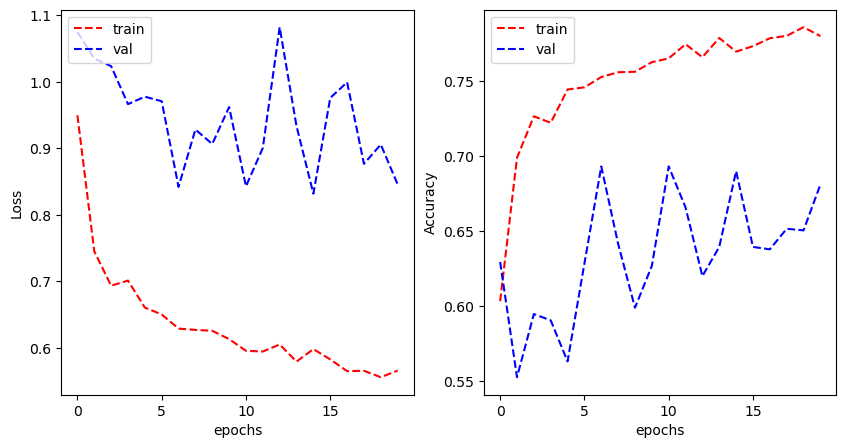

In [17]:
train_val_accuracy(history)